## 1. Investigate Dataset 

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import time

# Pandas for overview
import pandas as pd

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Plot setup
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')

import seaborn as sns

/Users/trushaparam/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 1.1 Load the dataset

**Print out some information (in text) about the data, to verify that the loading has worked and to get a feeling for what is present in the dataset and the range of the values.**

**Also, graphically show the proportions of the labels in the whole dataset.**

In [2]:
assignment_2 = pd.read_csv("assignment2.csv")
assignment_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    300 non-null    object 
 1   mean radius              300 non-null    float64
 2   mean texture             300 non-null    float64
 3   mean perimeter           300 non-null    float64
 4   mean area                300 non-null    float64
 5   mean smoothness          300 non-null    float64
 6   mean compactness         300 non-null    float64
 7   mean concavity           300 non-null    float64
 8   mean concave points      300 non-null    float64
 9   mean symmetry            300 non-null    float64
 10  mean fractal dimension   300 non-null    float64
 11  radius error             300 non-null    float64
 12  texture error            300 non-null    float64
 13  perimeter error          300 non-null    float64
 14  area error               3

<AxesSubplot:>

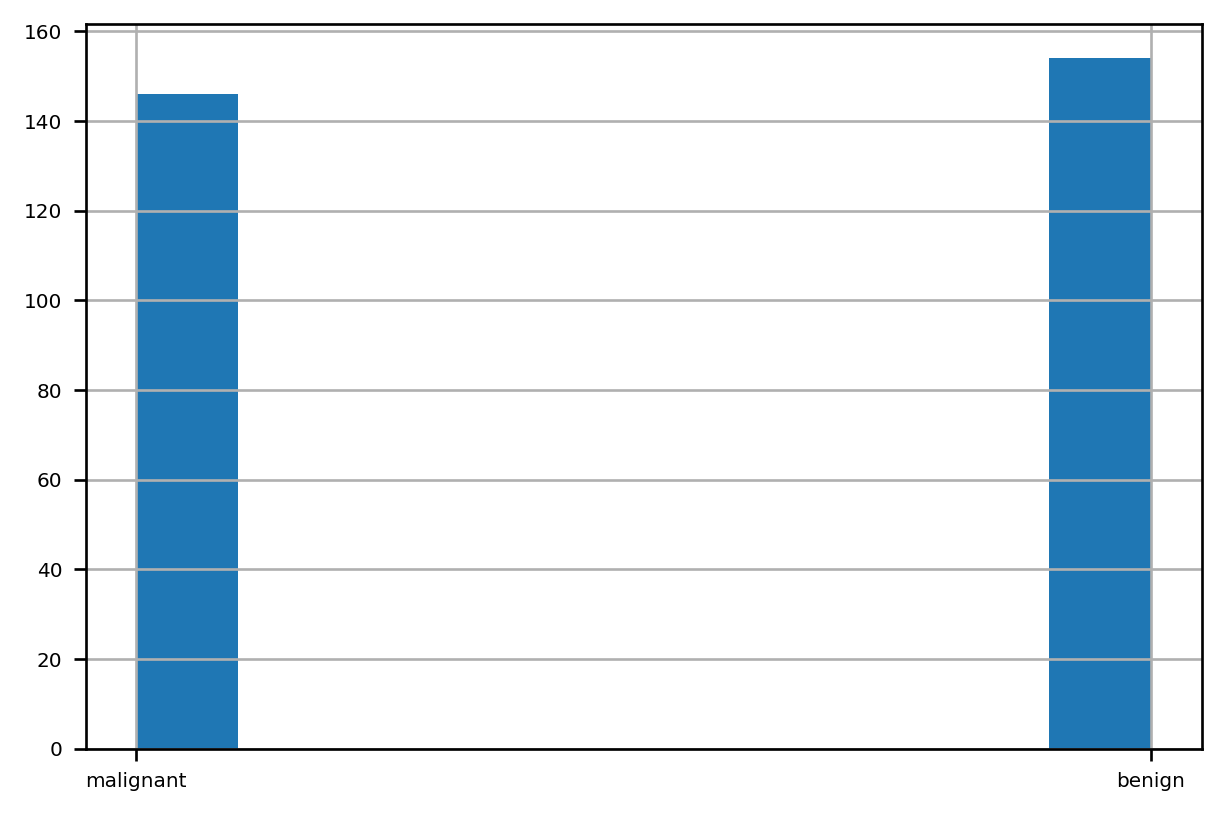

In [3]:
assignment_2["label"].hist()

### 1.2 Visualise the dataset 

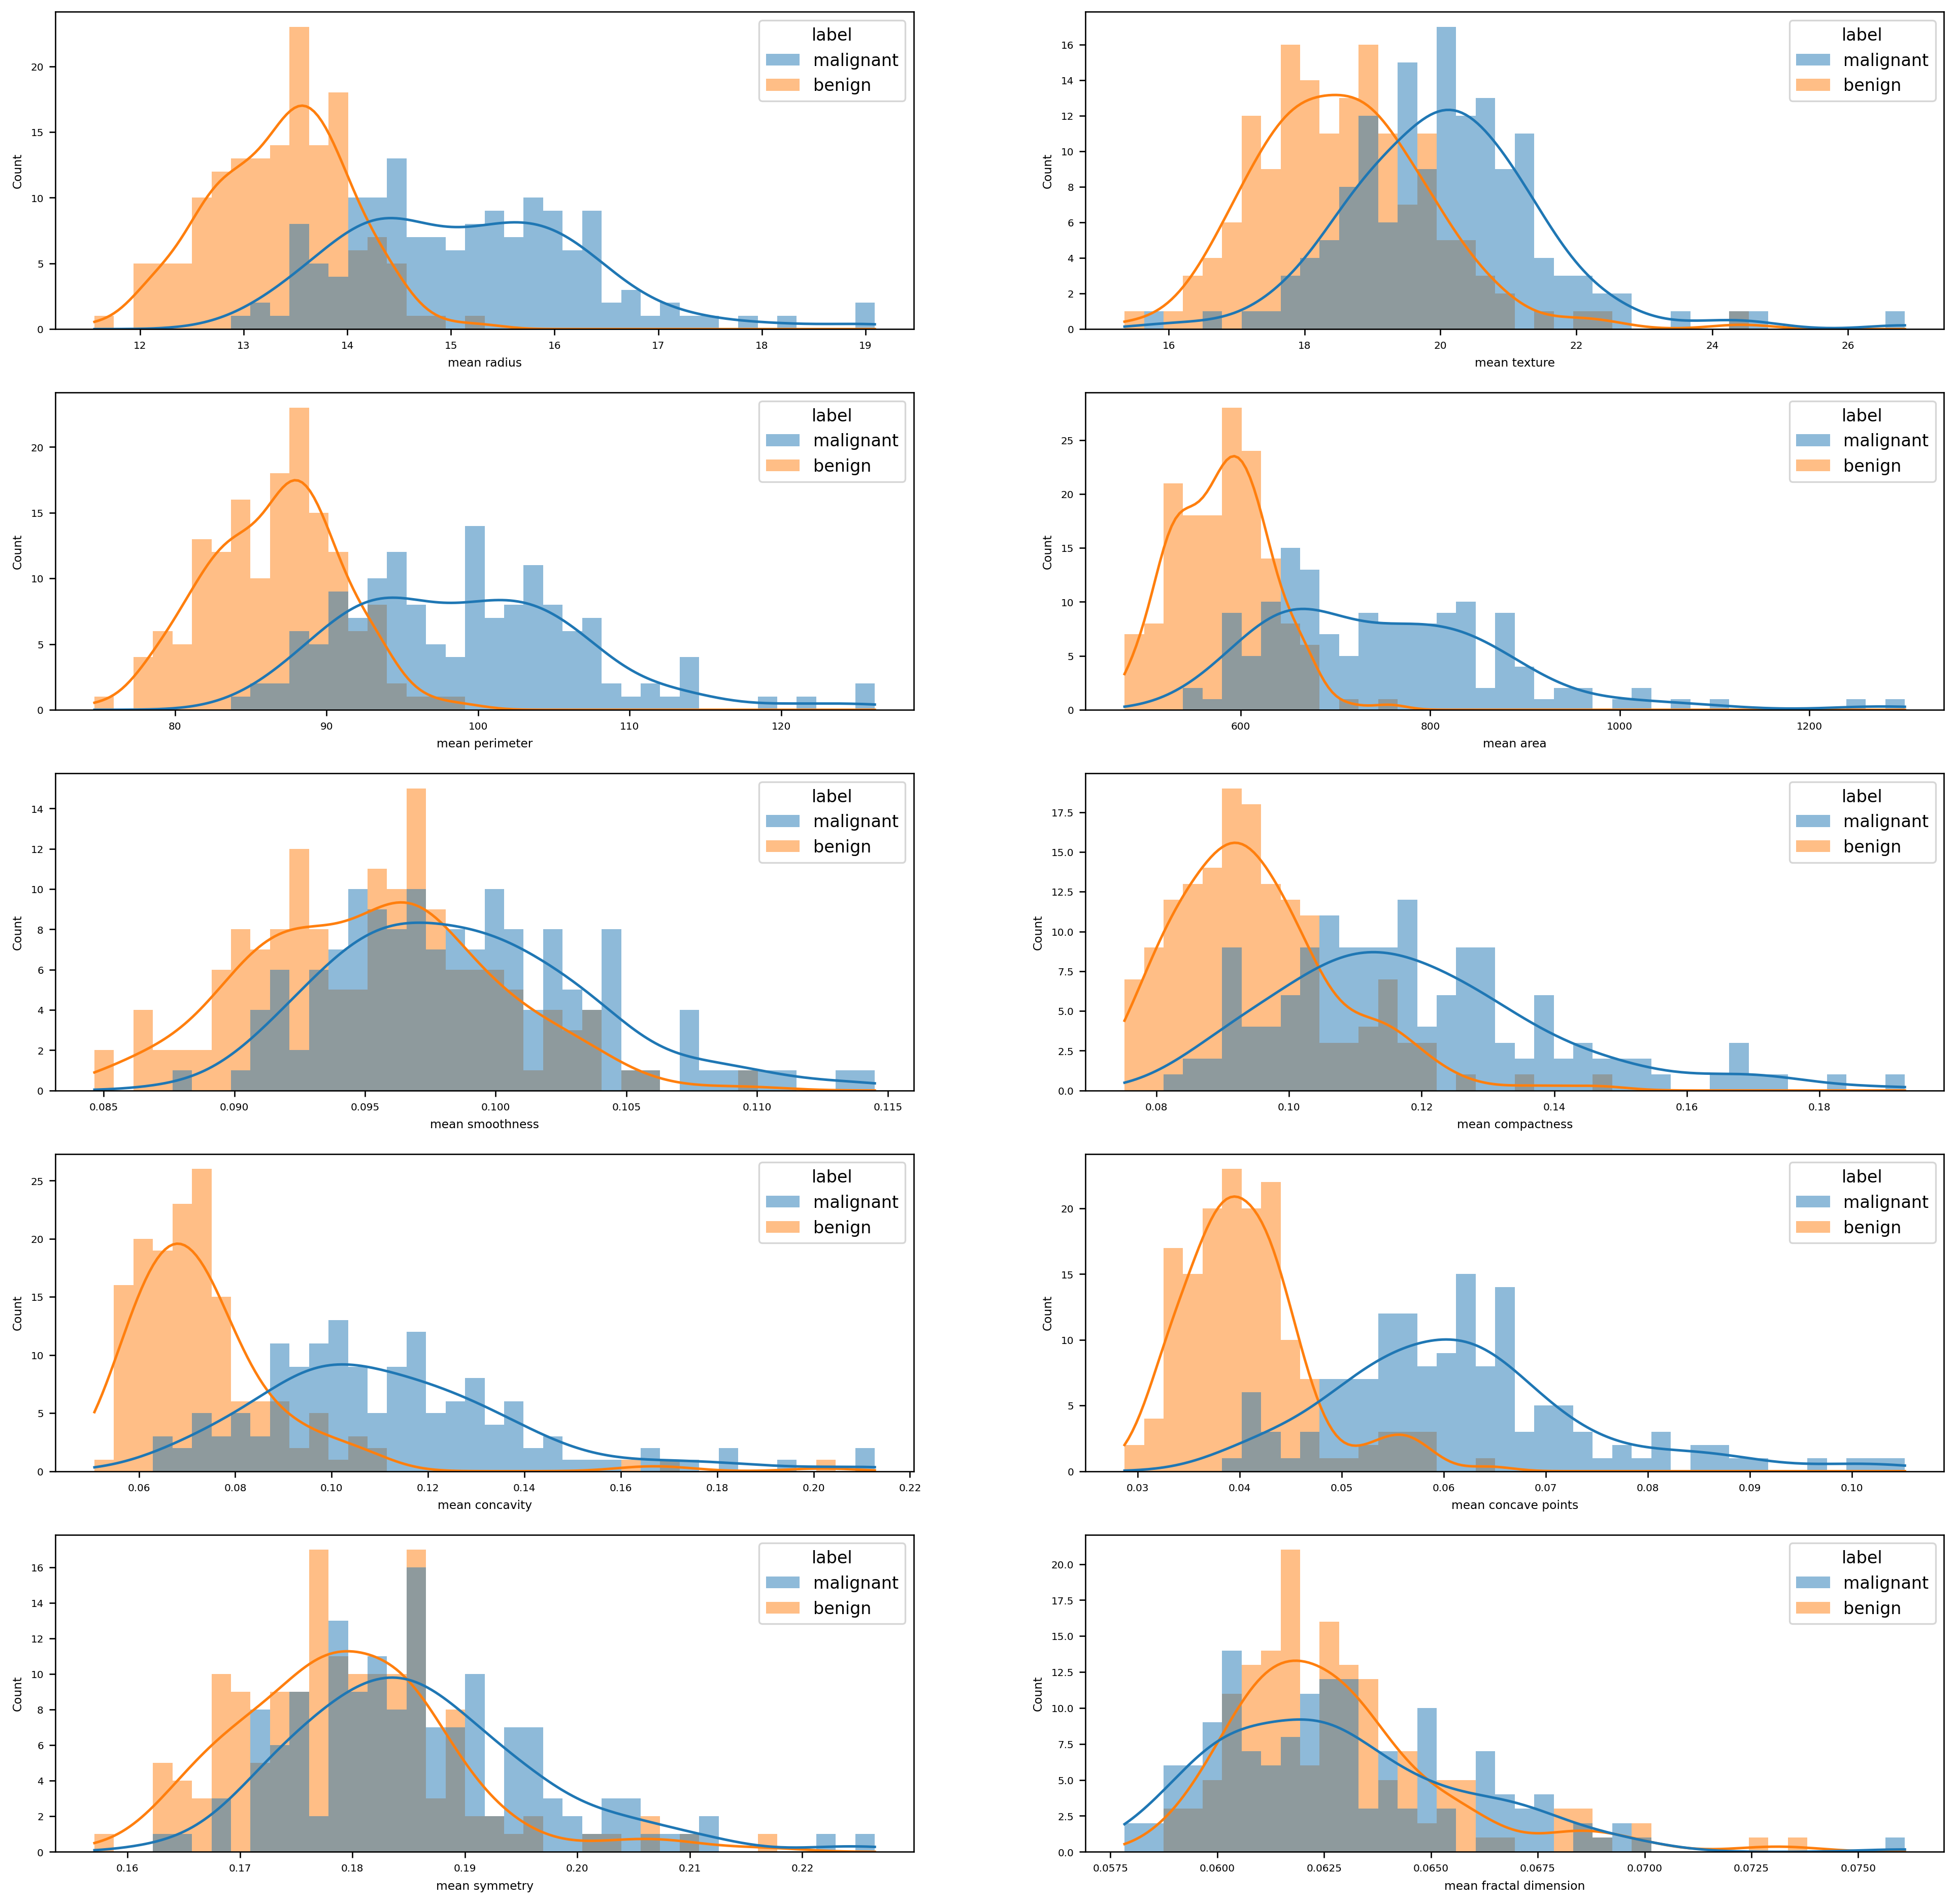

In [5]:
# histograms for each feature in the mean group
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
mean_features = assignment_2.iloc[:, 0:11]
i=1
while i<=10:
    for j in range(5):
        for k in range(2):
            sns.histplot(data=assignment_2, x = mean_features.columns[i], hue="label", bins=40, kde=True, ax=axes[j,k], edgecolor=None)
            i+=1
            

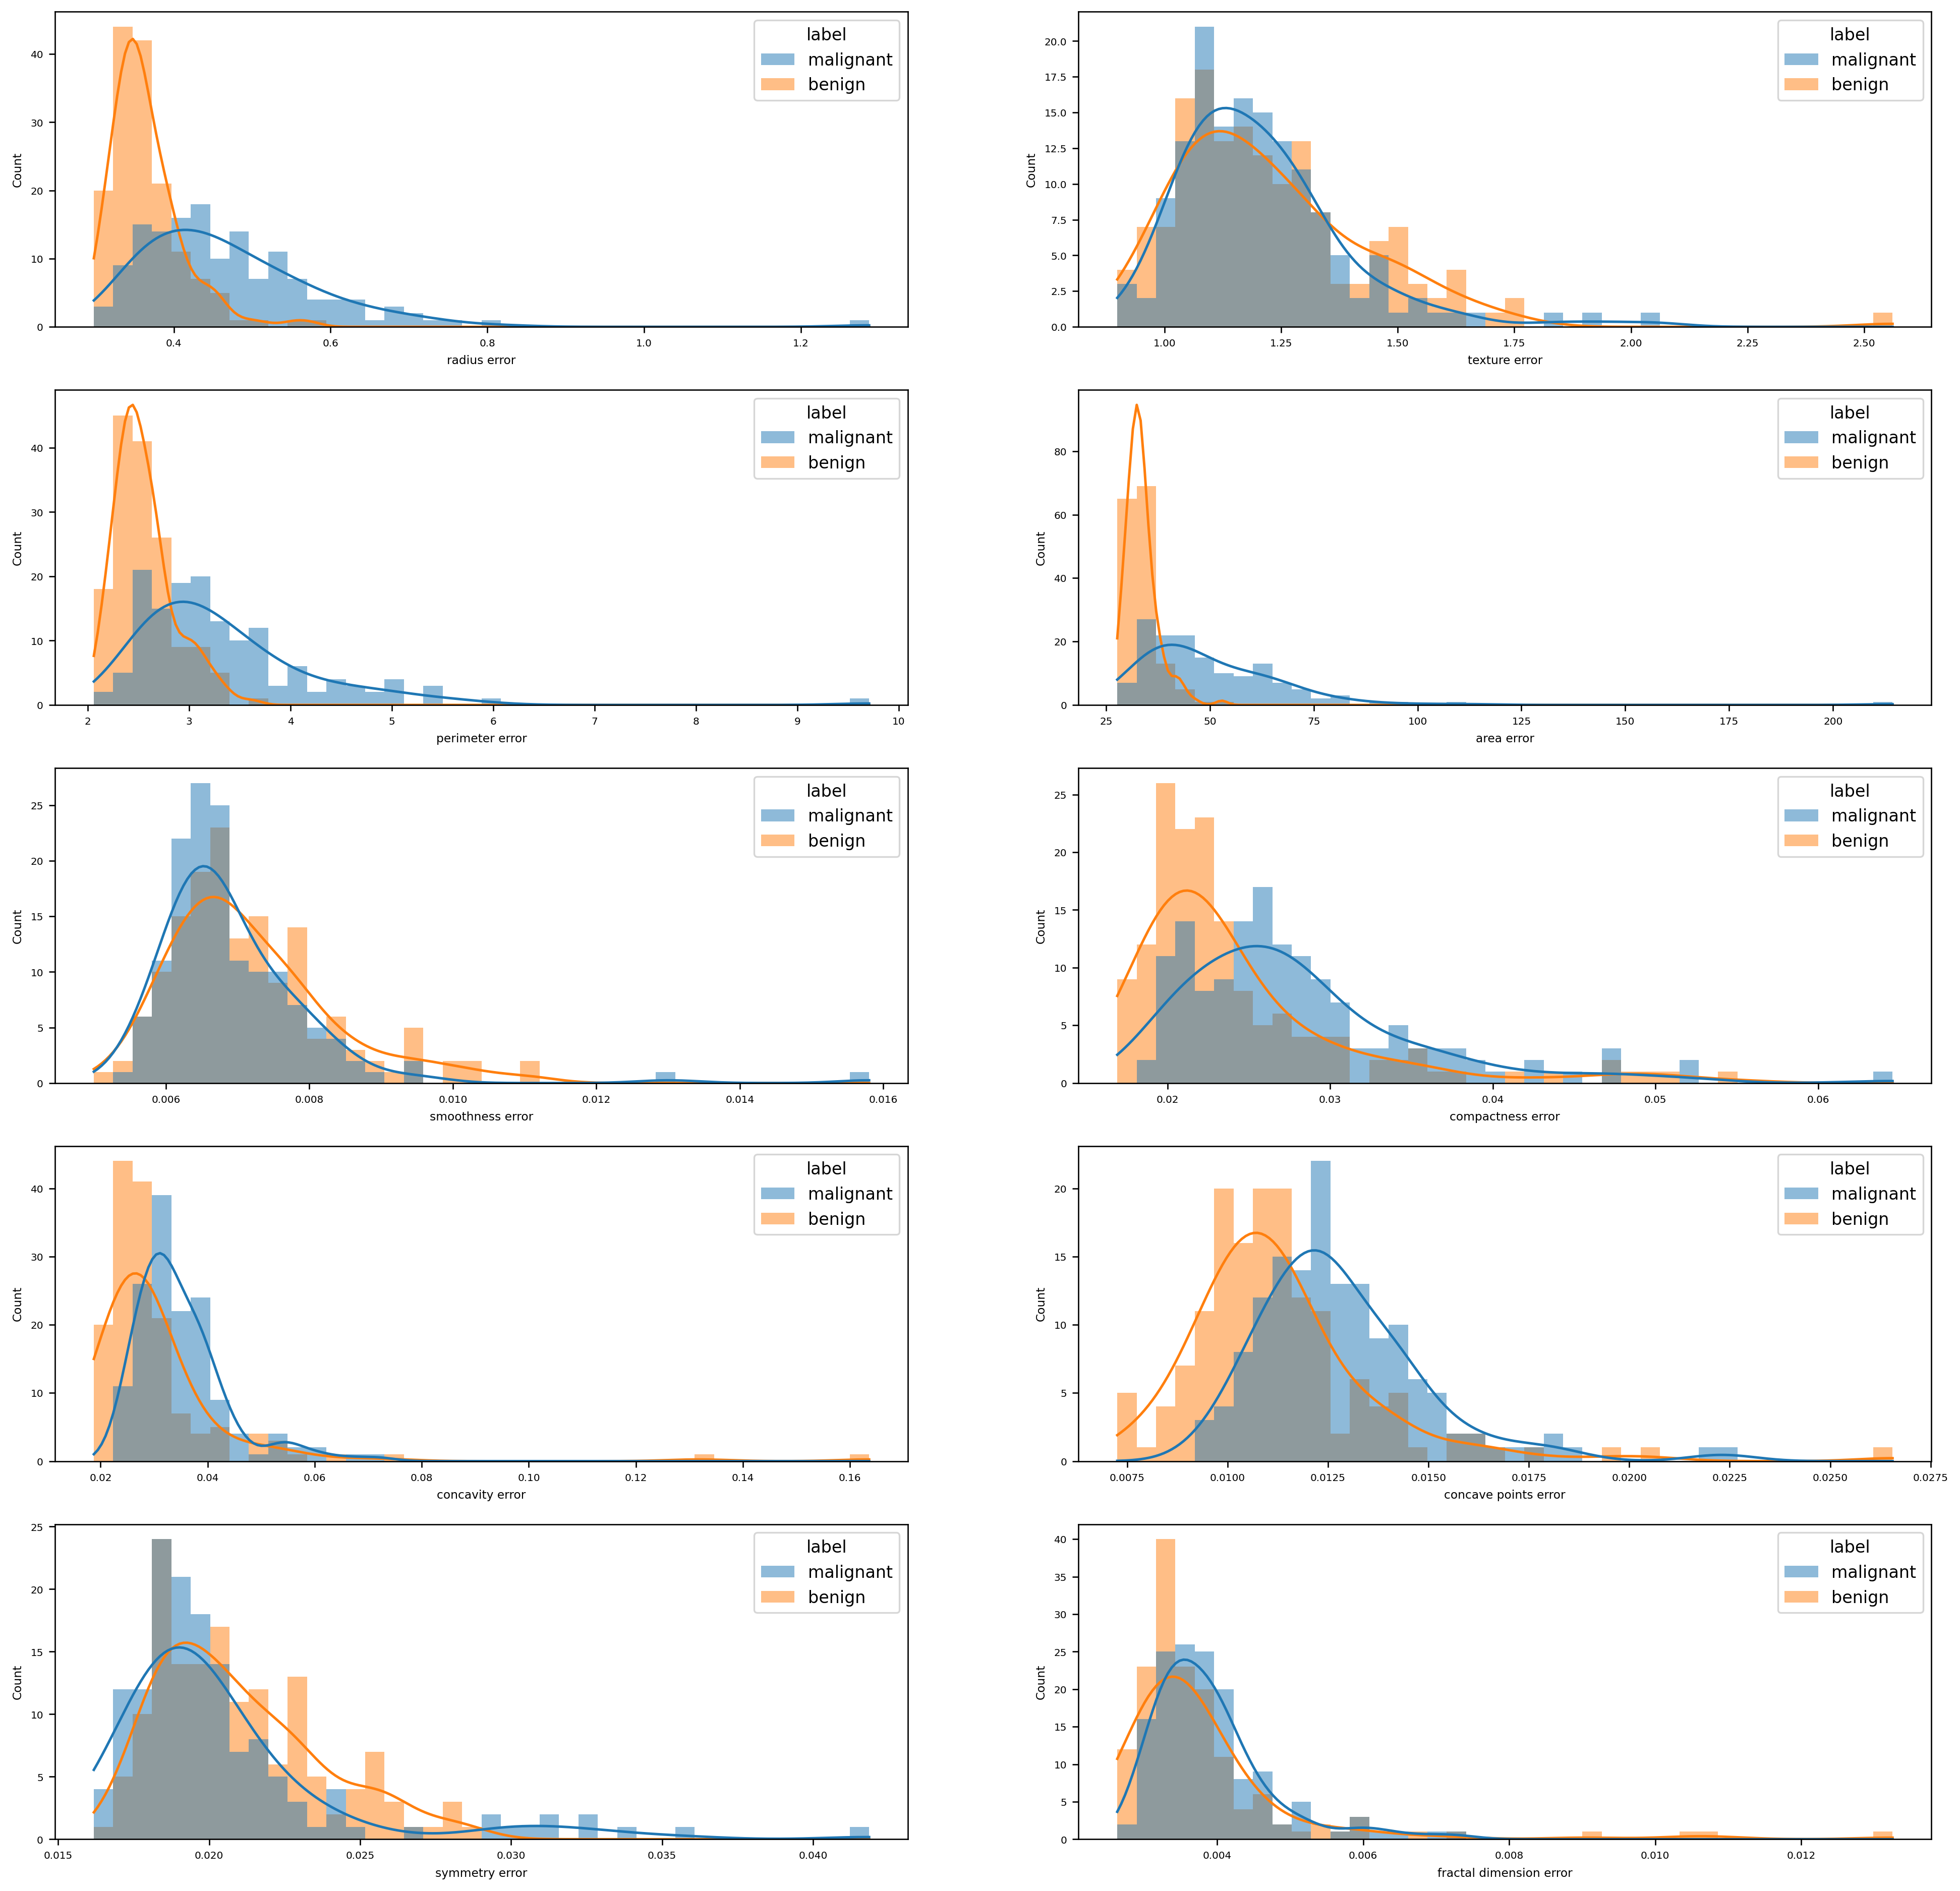

In [6]:
# histograms for each feature in the error group
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
error_features = assignment_2.iloc[:, 10:21]
i=1
while i<=10:
    for j in range(5):
        for k in range(2):
            sns.histplot(data=assignment_2, x = error_features.columns[i], hue="label", bins=40, kde=True, ax=axes[j,k], edgecolor=None)
            i+=1

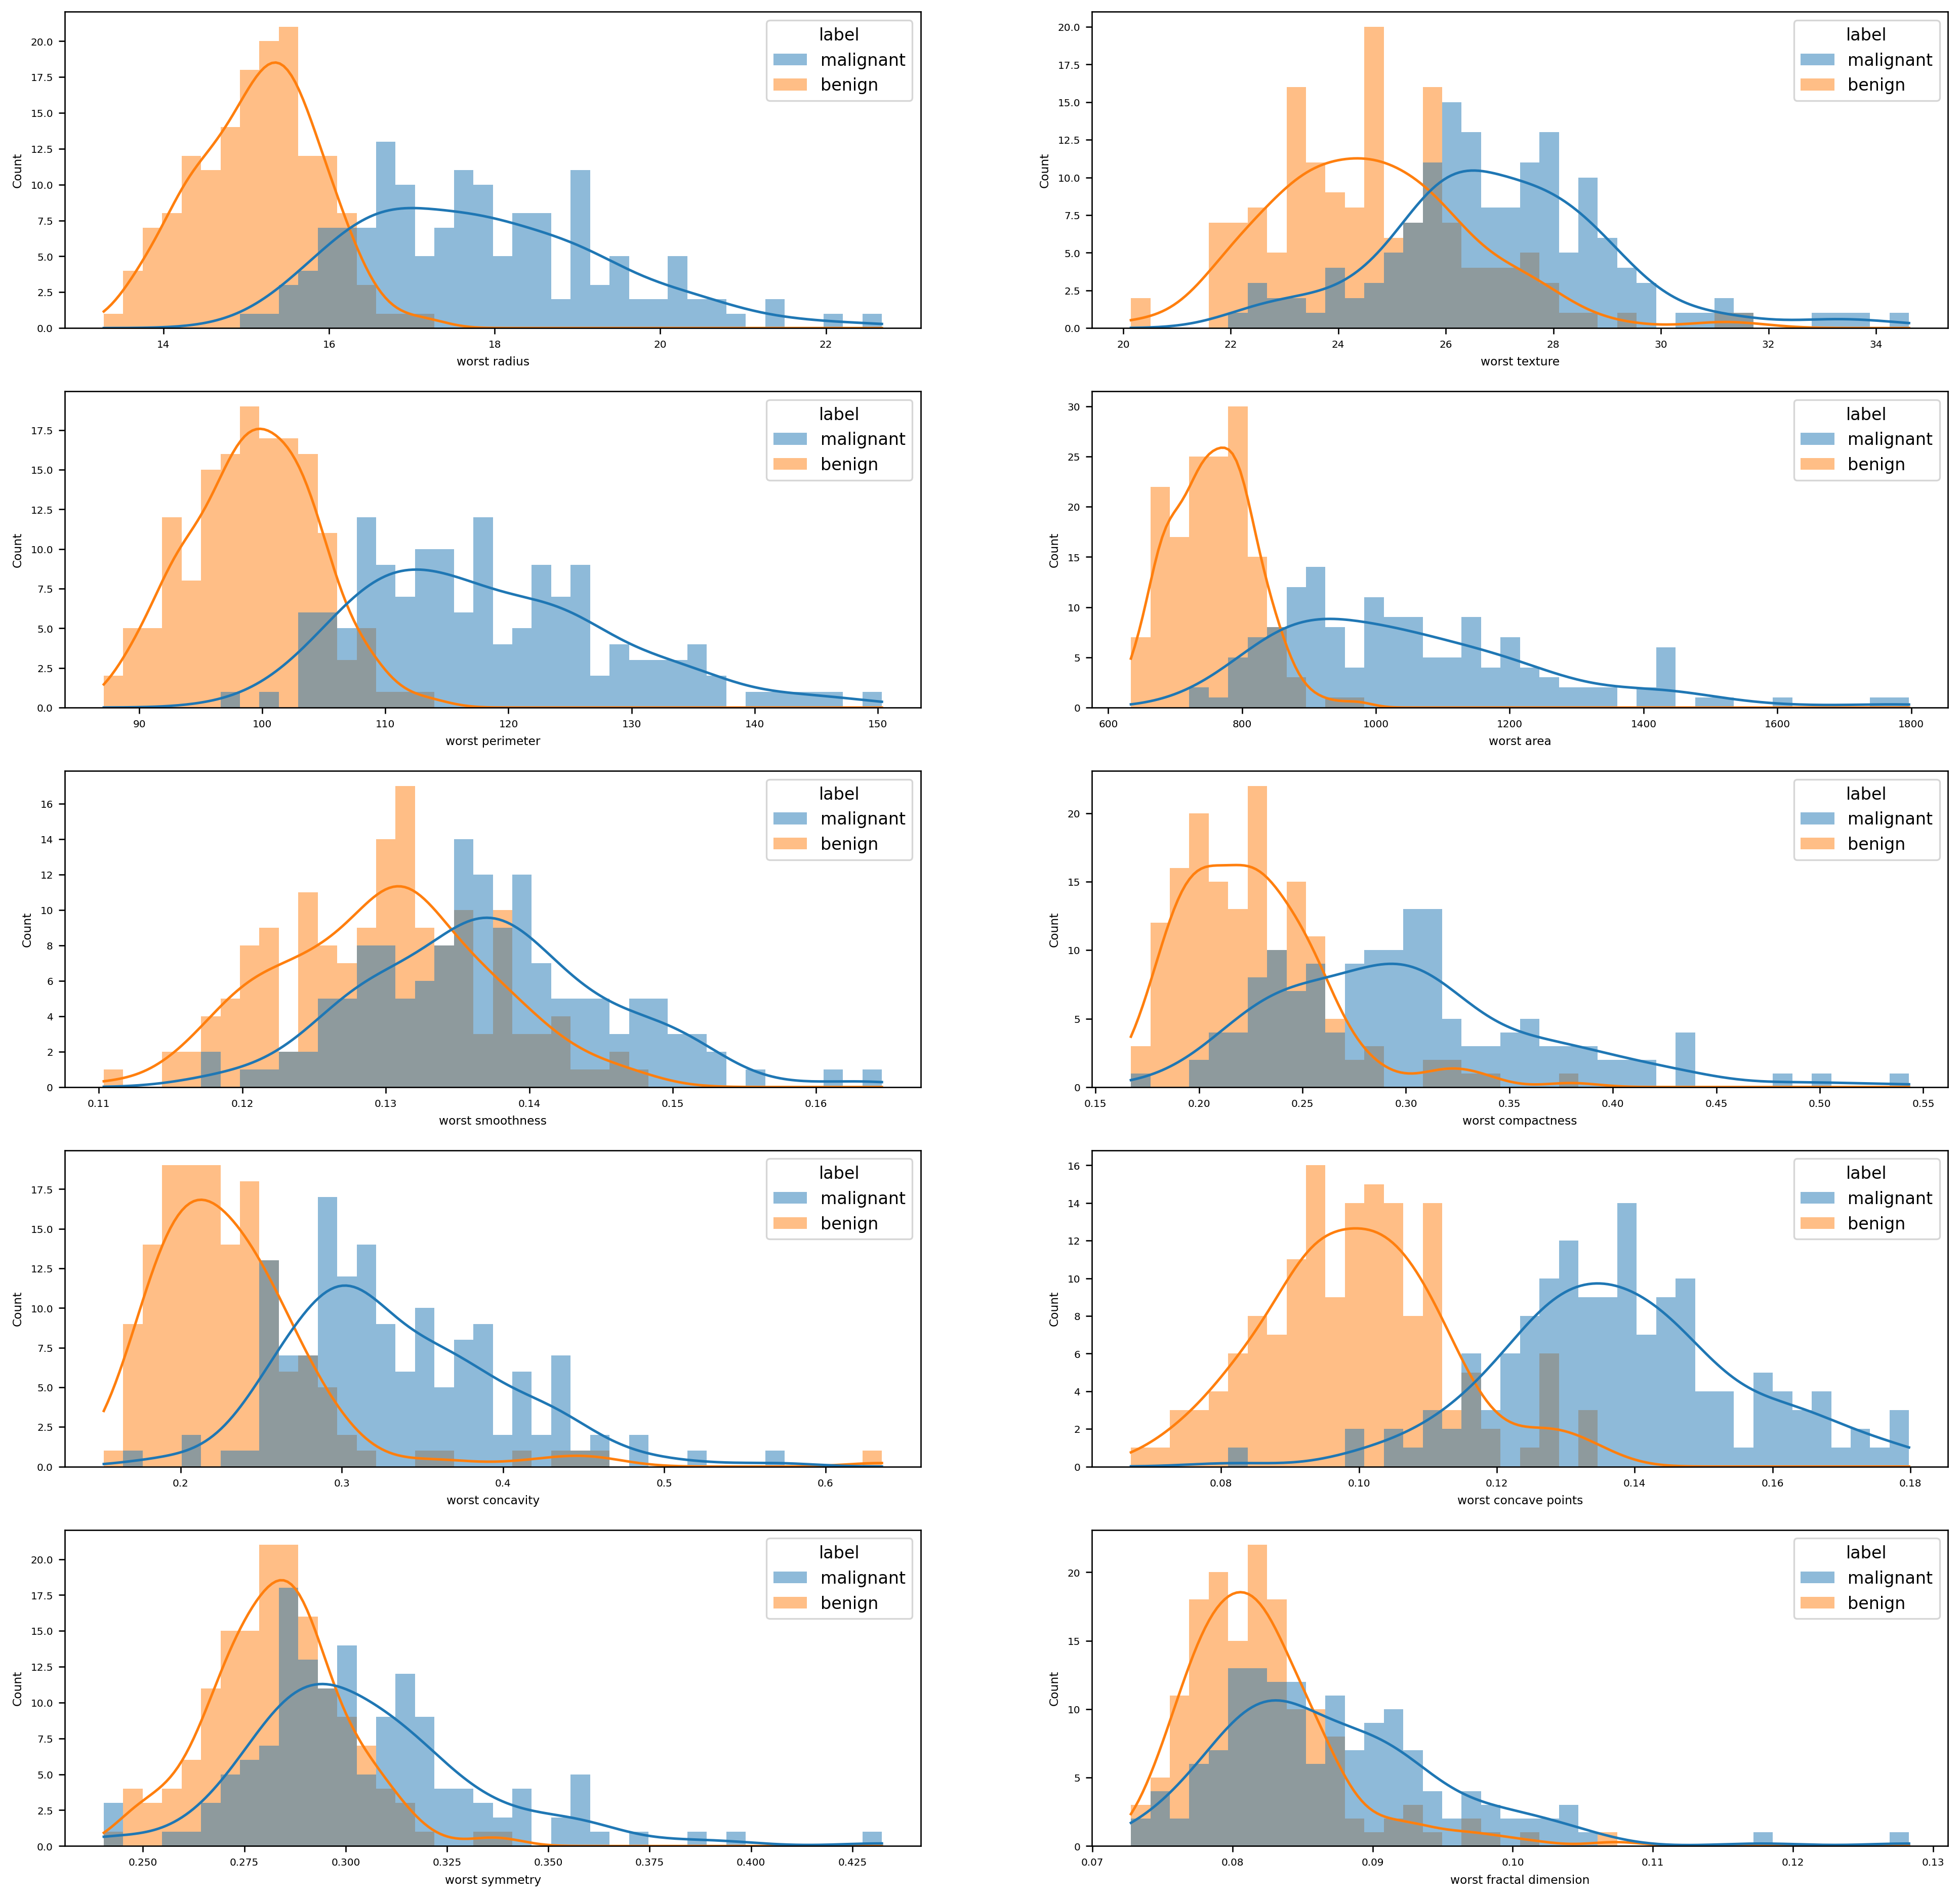

In [7]:
# histograms for each feature in the worst group
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
worst_features = assignment_2.iloc[:, 20:]
i=1
while i<=10:
    for j in range(5):
        for k in range(2):
            sns.histplot(data=assignment_2, x = worst_features.columns[i], hue="label", bins=40, kde=True, ax=axes[j,k], edgecolor=None)
            i+=1

### 1.3 Ranking the features 

**Based on the histograms, which do you think are the 3 strongest features for discriminating between the classes?**

Based on the histograms plotted above, we can see that the strongest features for discriminating between the classes are:

i) worst radius

ii) worst area

iii) worst parameter

Because these three parameters does not have that much overlapping and we can discriminate between classes.

### 1.4 Splitting the dataset

In [8]:
from sklearn.model_selection import train_test_split

assignment_2["label"] = assignment_2["label"].apply(lambda x: 1 if x == "malignant" else 0)

train_set, bigtest_set = train_test_split(assignment_2, test_size=0.3, random_state=42, stratify=assignment_2.iloc[:,0])
test_set, val_set = train_test_split(bigtest_set, test_size=0.5, random_state=42, stratify=bigtest_set.iloc[:,0])

# print(len(train_set))
# print(len(test_set))
# print(len(val_set))

X_train = train_set.iloc[:,1:]
y_train = train_set.iloc[:,0:1]
X_test = test_set.iloc[:,1:]
y_test = test_set.iloc[:,0:1]
X_val = val_set.iloc[:,1:]
y_val = val_set.iloc[:,0:1]
print(f'Shapes are {[X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape]}')
print(assignment_2['label'].value_counts())

Shapes are [(210, 30), (210, 1), (45, 30), (45, 1), (45, 30), (45, 1)]
0    154
1    146
Name: label, dtype: int64


## 2. Build, Train and Optimise Classifiers 

### 2.1 Pipeline
**Build a pre-processing pipeline** that includes imputation (as even though we don't strictly need it here it is a good habit to always include it) and other appropriate pre-processing.  

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

preproc_pl = Pipeline([ ('imputer', SimpleImputer(strategy="median")), 
                        ('RobustScaler', RobustScaler())])

### 2.2 Baseline measurements 

For our classification task we will consider **three simple baseline cases**:
1) predicting all samples to be negative (class 1)
2) predicting all samples to be positive (class 2)
3) making a random prediction for each sample with equal probability for each class

**For each case measure and display the following metrics:**
 - balanced accuracy
 - recall
 - precision
 - auc
 - f1score
 - fbeta_score with beta=0.1
 - fbeta_score with beta=10

Also **calculate and display the confusion matrix** for each baseline case, using a heatmap and numbers

In [10]:
baseline1 = np.full((210,1), 0, dtype = int)
baseline2 = np.full((210,1), 1, dtype = int)
baseline3 = np.random.choice([0,1],(210,1) ,p=[0.5,0.5])

In [11]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_auc_score

# Balanced Accuracy
def balance_acc(y_train, baseline):
    return balanced_accuracy_score(y_train, baseline)


balanced_acc_1 = balance_acc(y_train, baseline1)
print("Balanced accuracy for first case where all samples are negative: ", balanced_acc_1)

balanced_acc_2 = balance_acc(y_train, baseline2)
print("Balanced accuracy for second case where all samples are positive: ", balanced_acc_2)

balanced_acc_3 = balance_acc(y_train, baseline3)
print("Balanced accuracy for third case where samples are randomly predicted in equal proportion: ", balanced_acc_3)

# Recall
def recall_score_f(y_train, baseline):
    return recall_score(y_train, baseline)

recall_score_1 = recall_score_f(y_train, baseline1)
print("\nRecall score for first case where all sample are negative: ", recall_score_1)

recall_score_2 = recall_score_f(y_train, baseline2)
print("Recall score for second case where all sample are positive: ", recall_score_2)

recall_score_3 = recall_score_f(y_train, baseline3)
print("Recall score for third case where all sample are randomly predicted in equal proportion: ", recall_score_3)

#Precision
def precision_score_f(y_train, baseline):
    return precision_score(y_train, baseline)

precision_score_1 = precision_score_f(y_train, baseline1)
print("\nPrecision score for first case where all sample are negative: ", precision_score_1)

precision_score_2 = precision_score_f(y_train, baseline2)
print("Precision score for second case where all sample are positive: ", precision_score_2)

precision_score_3 = precision_score_f(y_train, baseline3)
print("Precision score for third case where all sample are randomly predicted in equal proportion: ", precision_score_3)

# auc score
def auc_score(y_train, baseline):
    return roc_auc_score(y_train, baseline)


auc_1 = auc_score(y_train, baseline1)
print("\nAuc score for first case where all sample are negative: ", auc_1)

auc_2 = auc_score(y_train, baseline2)
print("Auc score for second case where all sample are positive: ", auc_2)

auc_3 = auc_score(y_train, baseline3)
print("Auc score for third case where all sample are randomly predicted in equal proportion: ", auc_3)

# f1_score
def f1_score_f(y_train, baseline):
    return f1_score(y_train, baseline)

f1_score_1 = f1_score_f(y_train, baseline1)
print("\nf1 score for first case where all sample are negative: ", f1_score_1)

f1_score_2 = f1_score_f(y_train, baseline2)
print("f1 score for second case where all sample are positive: ", f1_score_2)

f1_score_3 = f1_score_f(y_train, baseline3)
print("f1 score for third case where all sample are randomly predicted in equal proportion: ", f1_score_3)


# fbeta
# f10_scorer = make_scorer(fbeta_score, beta=10)
# f01_scorer = make_scorer(fbeta_score, beta=0.1)

def f10_score(y_train, baseline1):
    return fbeta_score(y_train, baseline1, beta=10)

def f01_score(y_train, baseline1):
    return fbeta_score(y_train, baseline1, beta=0.1)


# fbeta_score with beta=0.1
fbeta_score_1 = f01_score(y_train, baseline1)
print("\nfbeta_score with beta = 0.1 for first case where all sample are negative: ", fbeta_score_1)

fbeta_score_2 = f01_score(y_train, baseline2)
print("fbeta_score with beta = 0.1 for second case where all sample are positive: ", fbeta_score_2)

fbeta_score_3 = f01_score(y_train, baseline3)
print("fbeta_score with beta = 0.1 for third case where all sample are randomly predicted in equal proportion: ", fbeta_score_3)


# fbeta_score with beta=10
fbeta_1 = f10_score(y_train, baseline1)
print("\nfbeta_score with beta = 10 for first case where all sample are negative: ", fbeta_1)

fbeta_2 = f10_score(y_train, baseline2)
print("fbeta_score with beta = 10 for second case where all sample are positive: ", fbeta_2)

fbeta_3 = f10_score(y_train, baseline3)
print("fbeta_score with beta = 10 for third case where all sample are randomly predicted in equal proportion: ", fbeta_3)


Balanced accuracy for first case where all samples are negative:  0.5
Balanced accuracy for second case where all samples are positive:  0.5
Balanced accuracy for third case where samples are randomly predicted in equal proportion:  0.5040849673202614

Recall score for first case where all sample are negative:  0.0
Recall score for second case where all sample are positive:  1.0
Recall score for third case where all sample are randomly predicted in equal proportion:  0.4803921568627451

Precision score for first case where all sample are negative:  0.0
Precision score for second case where all sample are positive:  0.4857142857142857
Precision score for third case where all sample are randomly predicted in equal proportion:  0.49

Auc score for first case where all sample are negative:  0.5
Auc score for second case where all sample are positive:  0.5
Auc score for third case where all sample are randomly predicted in equal proportion:  0.5040849673202614

f1 score for first case where

/Users/trushaparam/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
from sklearn.metrics import fbeta_score, make_scorer

f10_scorer = make_scorer(fbeta_score, beta=10)
f01_scorer = make_scorer(fbeta_score, beta=0.1)

def f10_score(y_train, baseline1):
    return fbeta_score(y_train, baseline1, beta=10)

def f01_score(y_train, baseline1):
    return fbeta_score(y_train, baseline1, beta=0.1)

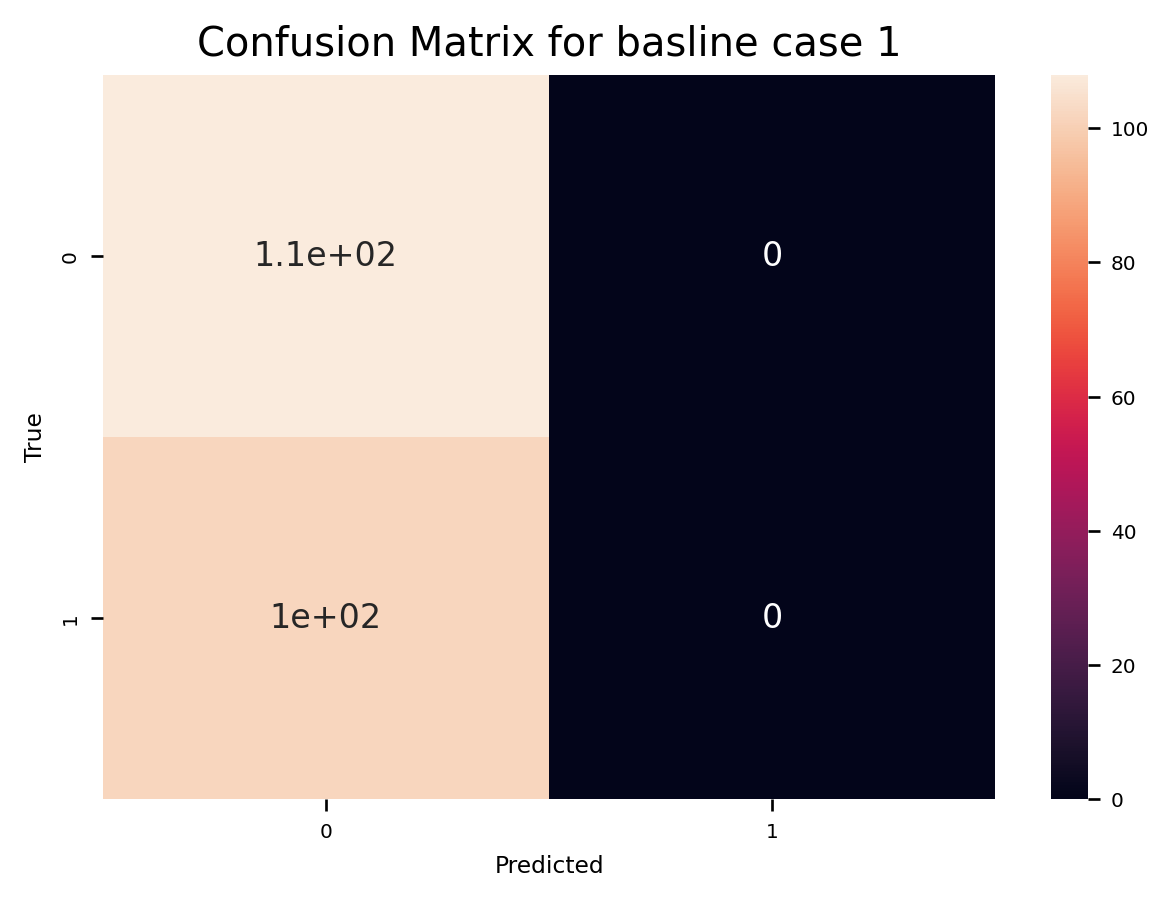

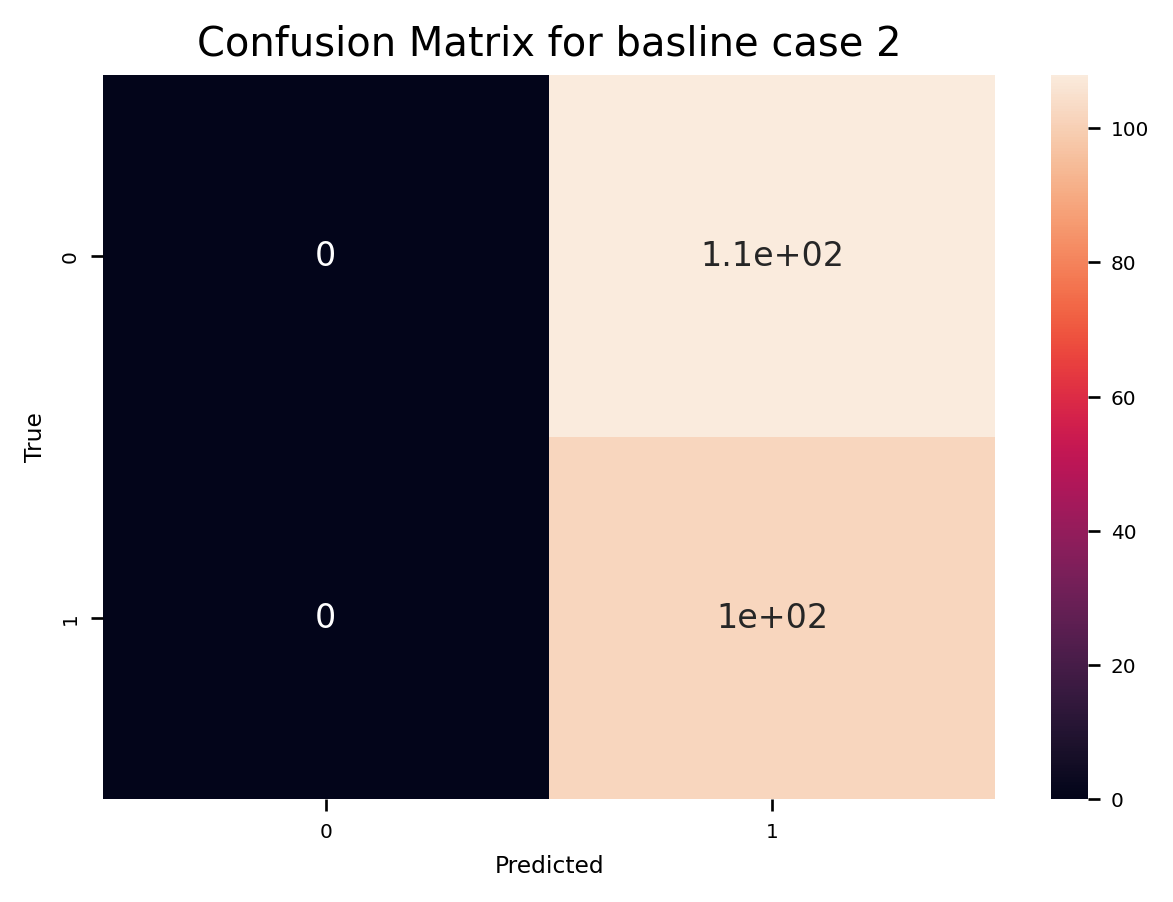

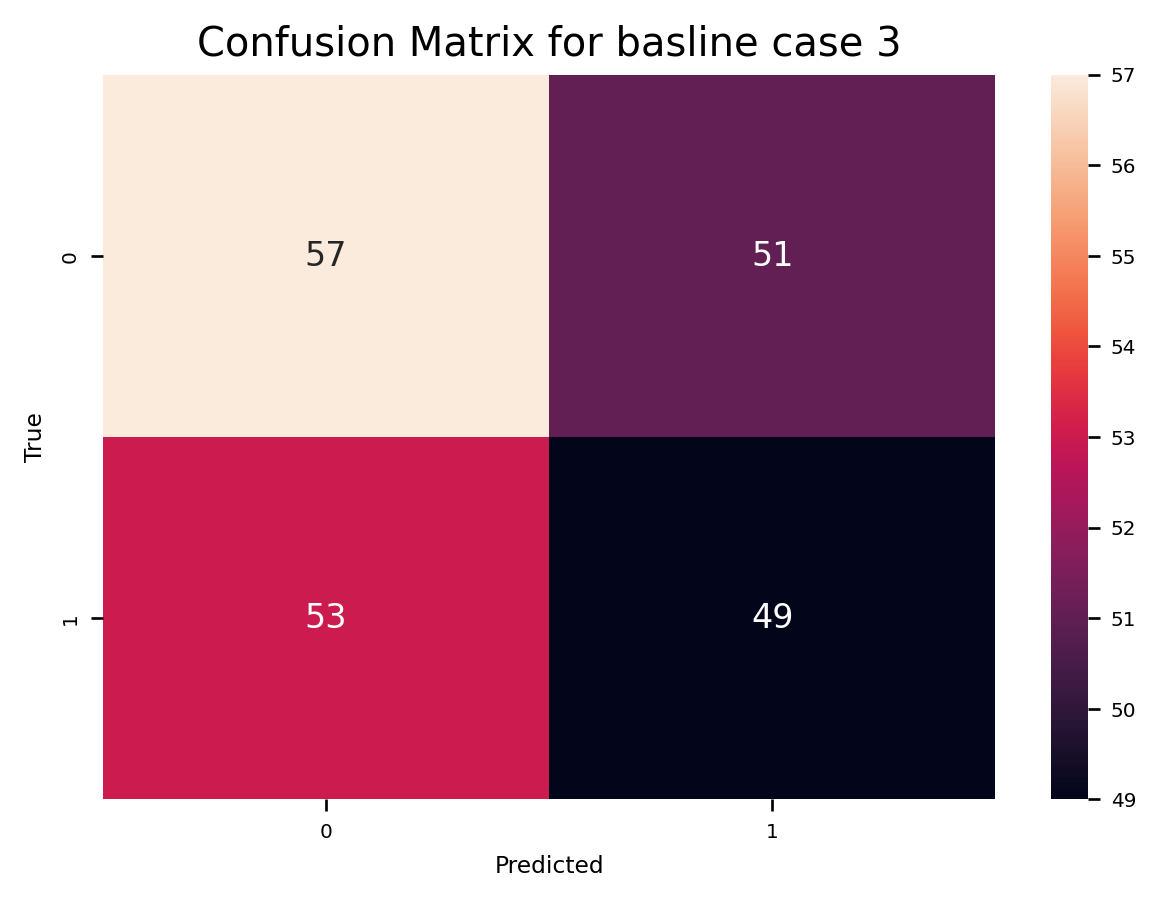

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

def confusion_matrix_f(y_train, baseline):
    return confusion_matrix(y_true = y_train, y_pred = baseline)

# baseline1
cmat_1 = confusion_matrix_f(y_train, baseline1)
sn.heatmap(cmat_1,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for basline case 1')
plt.show()

# baseline 2
cmat_2 = confusion_matrix_f(y_train, baseline2)
sn.heatmap(cmat_2,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for basline case 2')
plt.show()

# baseline 3
cmat_3 = confusion_matrix_f(y_train, baseline3)
sn.heatmap(cmat_3,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for basline case 3')
plt.show()

### 2.3 Choose a performance metric


Based on the baseline tests and client's requirements, I am choosing my fbeta score when beta is equal to 10. Because, when beta > 1, it favors recall and as we want more of recall values than precision, and the values obtained satisfies the client's requirement giving fbeta score as 98.9625% which is having at least a 95% probability of detecting malignant cancer when it is present.

### 2.4 SGD baseline 

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import hinge_loss
sgd = SGDClassifier(random_state=40)
sgd.fit(X_train.values,y_train.values)
y_val_pred = sgd.predict(X_val.values)
acc = accuracy_score(y_val.values, y_val_pred)
loss = hinge_loss(y_val.values, y_val_pred)
print(acc, loss)

0.8222222222222222 0.6888888888888889


/Users/trushaparam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### 2.5 Confusion matrix 

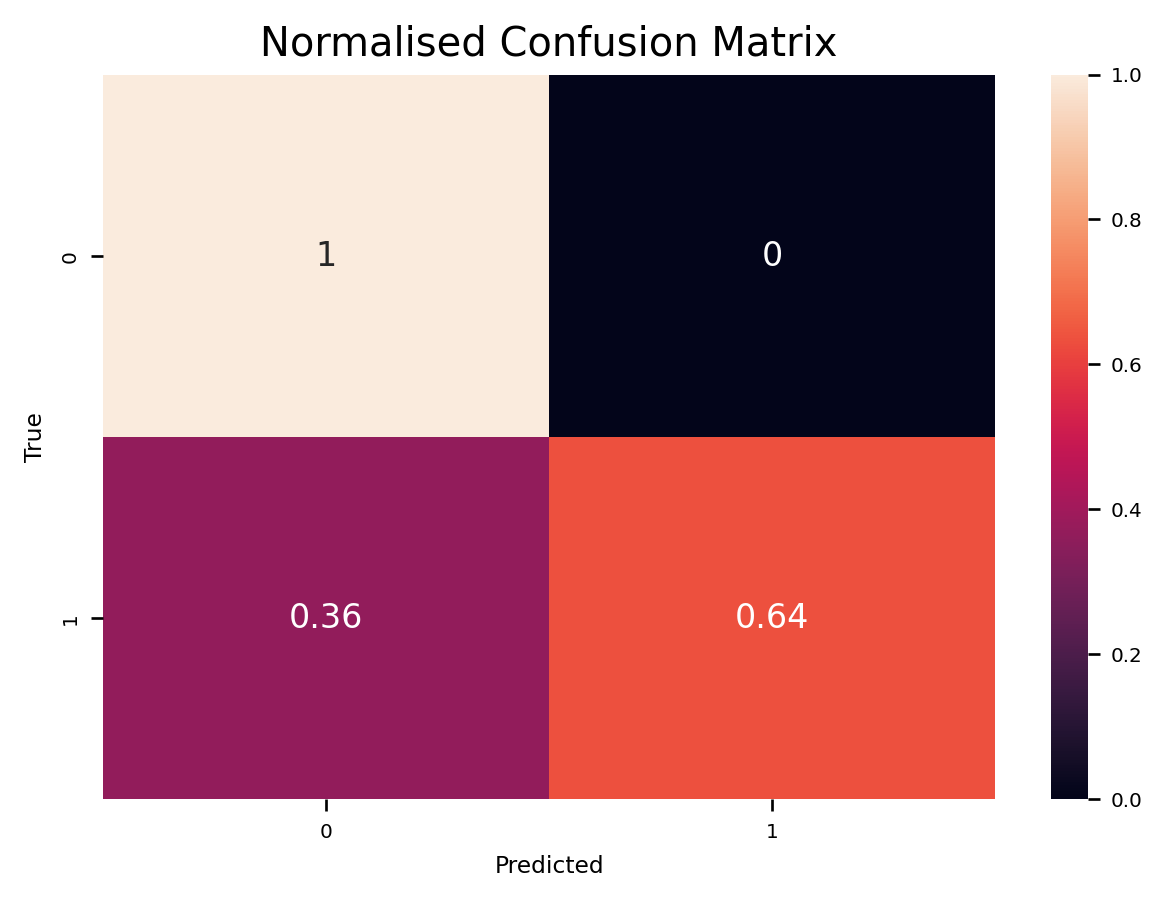

In [15]:

cmat_n = confusion_matrix(y_true=y_val, y_pred=y_val_pred, normalize='true')
sn.heatmap(cmat_n,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()


The probability that a sample from a person with a malignant tumour is given a result that they do not have cancer which in the confusion matrix means false positive which we got 0 which satisfies the client's second condition that is have no more than 1 in 10 healthy cases (those with benign tumours) labelled as positive (malignant). 

Also we can see that the false negative value is 1.
Similarly, we got true psoitive as 0.64 and true negative as 0.36.

### 2.6 Main classifier 

In [16]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

alpha = np.arange(1, 5, 0.5)

#KNN classifier
def knn_function(X_train, X_val):
    n_neigh = np.arange(1,10,1)
    knn_pl = Pipeline([('preproc',preproc_pl), ('knn', KNeighborsClassifier())])
    gridcv_knn = GridSearchCV(knn_pl, {'knn__n_neighbors':n_neigh}, cv=10)
    gridcv_knn.fit(X_train, y_train.values.reshape(-1,))
    y_val_pred_knn = gridcv_knn.predict(X_val)
    return  (gridcv_knn.best_params_)

knn_c = knn_function(X_train.values, X_val.values)
print(f'Best params using KNN classifier is {knn_c}')

# Decision tree classifier
def dtc_function(X_train, X_val):
    dt_pl = Pipeline([ ('preproc',preproc_pl), ('dtc', DecisionTreeClassifier())])
    gridcv_dt = GridSearchCV(dt_pl, {'dtc__ccp_alpha': alpha}, cv=10)
    gridcv_dt.fit(X_train, y_train.values.reshape(-1,))
    return (gridcv_dt.best_params_)
    
dtc_c = dtc_function(X_train.values, X_val.values)
print(f'\nBest params using Decision Tree classifier is {dtc_c}')

# SVM classifier
def svm_function(X_train, X_val):
    svm_pl = Pipeline([('preproc',preproc_pl), ('svc', SVC())])
    gridcv_svm = GridSearchCV(svm_pl, {'svc__C': alpha}, cv=10)
    gridcv_svm.fit(X_train, y_train.values.reshape(-1,))
    return (gridcv_svm.best_params_)

svm_c = svm_function(X_train.values, X_val.values)
print(f'\nBest params using SVM classifier is {svm_c}')

# SGD classifier
def sgd_function(X_train, X_val):
    sgd_pl = Pipeline([ ('preproc',preproc_pl), ('sgd',SGDClassifier(loss='log')) ])
    gridcv_sgd = GridSearchCV(sgd_pl, {'sgd__alpha': alpha}, cv=10)
    gridcv_sgd.fit(X_train, y_train.values.reshape(-1,))
    return (gridcv_sgd.best_params_)

sgd_c = sgd_function(X_train.values, X_val.values)
print(f'\nBest params using SGD classifier is {sgd_c}')

Best params using KNN classifier is {'knn__n_neighbors': 5}

Best params using Decision Tree classifier is {'dtc__ccp_alpha': 1.0}

Best params using SVM classifier is {'svc__C': 1.0}

Best params using SGD classifier is {'sgd__alpha': 1.5}


In [17]:
#Pipeline

# KNN classifier 
def optimal_knn(X_train, X_val, n):
    knn_pl_o = Pipeline([('preproc',preproc_pl), ('knn', KNeighborsClassifier(n_neighbors=n))])
    knn_pl_o = knn_pl_o.fit(X_train, y_train.values.reshape(-1,))
    y_test_pred_knn_o = knn_pl_o.predict(X_val)
    knn_acc = balanced_accuracy_score(y_true = y_val.values, y_pred = y_test_pred_knn_o)
    knn_fbeta = fbeta_score(y_val.values, y_test_pred_knn_o, beta=10)
    return (knn_acc, knn_fbeta)

knn_o = optimal_knn(X_train.values, X_val.values, 5)
print(f'Balaned Accuracy for KNN classifier is {knn_o[0]}')
print(f'fbeta score(beta = 10) for KNN classifier is {knn_o[1]}')

# Decision Tree Classifier
def optimal_dt(X_train, X_val, n):
    dt_pl_o = Pipeline([ ('preproc',preproc_pl), ('dtc', DecisionTreeClassifier(ccp_alpha=n))])
    dt_pl_o = dt_pl_o.fit(X_train, y_train.values.reshape(-1,))
    y_test_pred_dt_o = dt_pl_o.predict(X_val)
    dt_acc = balanced_accuracy_score(y_true = y_val.values, y_pred = y_test_pred_dt_o)
    dt_fbeta = fbeta_score(y_val.values, y_test_pred_dt_o, beta=10)
    return (dt_acc, dt_fbeta)
dt_o = optimal_dt(X_train.values, X_val.values, 1.0)
print(f'\nBalanced Accuracy for Decision Tree classifier is {dt_o[0]}')
print(f'fbeta score(beta = 10) for Decision Tree classifier is {dt_o[1]}')

#SVM classifier
def optimal_svm(X_train, X_val, n):
    svm_pl_o = Pipeline([('preproc',preproc_pl), ('svc', SVC(C=n))])
    svm_pl_o = svm_pl_o.fit(X_train, y_train.values.reshape(-1,))
    y_test_pred_svm_o = svm_pl_o.predict(X_val)
    svm_acc = balanced_accuracy_score(y_true = y_val.values, y_pred = y_test_pred_svm_o)
    svm_fbeta = fbeta_score(y_val.values, y_test_pred_svm_o, beta=10)
    return (svm_acc, svm_fbeta)
svm_o = optimal_svm(X_train.values, X_val.values, 1.0)
print(f'\nBalanced Accuracy for SVM classifier is {svm_o[0]}')
print(f'fbeta score(beta = 10) for SVM classifier is {svm_o[1]}')

# SGD classifier
def optimal_sgd(X_train, X_val, n):
    sgd_pl_o = Pipeline([ ('preproc',preproc_pl), ('sgd',SGDClassifier(alpha=n))])
    sgd_pl_o = sgd_pl_o.fit(X_train, y_train.values.reshape(-1,))
    y_test_pred_sgd_o = sgd_pl_o.predict(X_val)
    sgd_acc = balanced_accuracy_score(y_true = y_val.values, y_pred = y_test_pred_sgd_o)
    sgd_fbeta = fbeta_score(y_val.values, y_test_pred_sgd_o, beta=10)
    return (sgd_acc, sgd_fbeta)
sgd_o = optimal_sgd(X_train.values, X_val.values, 1.5)
print(f'\nBlalanced Accuracy for SGD classifier is {sgd_o[0]}')
print(f'fbeta score(beta = 10) for SGD classifier is {sgd_o[1]}')

Balaned Accuracy for KNN classifier is 0.9337944664031621
fbeta score(beta = 10) for KNN classifier is 0.9541160593792173

Balanced Accuracy for Decision Tree classifier is 0.5
fbeta score(beta = 10) for Decision Tree classifier is 0.0

Balanced Accuracy for SVM classifier is 0.9782608695652174
fbeta score(beta = 10) for SVM classifier is 0.9995501574448943

Blalanced Accuracy for SGD classifier is 0.9318181818181819
fbeta score(beta = 10) for SGD classifier is 0.8648039657503381


From the above results we can say that the best 3 classifiers are :

i)KNN

ii)SVM

iii)SGD

And somewhat SVM and SGD are giving same outputs, thus performing somewhat equivalently. 


### 2.7 Model selection 

Based on the results, I'm choosing SVM classifier which has the best parameter as 1, as it is giving the best results as fbeta values above 95%. Also as the fbeta score is more inclined towards recall which is sensitivity which describes true positive rate and thus it satisfies the first condition of the client. 

### 2.8 Final performance

In [18]:
# SVM classifier
def optimal_svm_test(X_train, X_test, n):
    svm_pl = Pipeline([('preproc',preproc_pl), ('svc', SVC(C=n))])
    svm_pl = svm_pl.fit(X_train, y_train.values.reshape(-1,))
    y_test_pred_svm = svm_pl.predict(X_test)
    svm_acc = balanced_accuracy_score(y_true = y_test.values, y_pred = y_test_pred_svm)
    svm_fbeta = fbeta_score(y_test.values, y_test_pred_svm, beta=10)
    return (svm_acc, svm_fbeta)
svm_test = optimal_svm_test(X_train.values, X_test.values, 1.0)
print(f'Accuracy for SVM classifier is {svm_test[0]}')
print(f'fbeta score(beta = 10) for SVM classifier is {svm_test[1]}')

Accuracy for SVM classifier is 0.9772727272727273
fbeta score(beta = 10) for SVM classifier is 0.954975236380009



We can say that the classifier that we used is neither underfitting nor overfitting and it also meets the client's performance criteria.

## 3. Decision Boundaries

### 3.1 Rank features 

In [19]:
# seperate positive and negative
train_set_1 = train_set.loc[(train_set['label']==1)]
train_set_0 = train_set.loc[(train_set['label']==0)]

# remove labels
train_set_1 = train_set_1.drop(["label"], axis=1)
train_set_0 = train_set_0.drop(["label"], axis=1)
train_set_0
t_score = []
for i in train_set_1:
    ans = ((train_set_1[i].mean()) - (train_set_0[i].mean()))/(0.5*(train_set_1[i].std() + train_set_0[i].std()))
    t_score.append((ans, i))
t_score.sort(reverse = True)
print(t_score[:4])

[(2.287501733921719, 'worst concave points'), (2.202348558522395, 'worst perimeter'), (2.1342289781344874, 'worst radius'), (2.046298586340423, 'mean concave points')]


### 3.2 Visualise decision boundaries 

In [20]:
def make_meshgrid(x, y, ns=100):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on (only min and max used)
    y: data to base y-axis meshgrid on (only min and max used)
    ns: number of steps in grid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    hx = (x_max - x_min)/ns
    hy = (y_max - y_min)/ns
    xx, yy = np.meshgrid(np.arange(x_min, x_max + hx, hx), np.arange(y_min, y_max + hy, hy))
    return xx, yy

In [21]:
def plot_contours(clf, xx, yy, xmean, n1, n2, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    xmean : 1d array of mean values (to populate constant features with)
    n1, n2: index numbers of features that change (for xx and yy)
    params: dictionary of params to pass to contourf, optional
    """
    # The following lines makes an MxN matrix to pass to the classifier (# samples x # features)
    # It does this by multiplying Mx1 and 1xN matrices, where the former is filled with 1's
    #  where M is the number of grid points in xx and N is the number of features in xmean
    #  It is done in such a way that the xmean vector is replaced in each row
    fullx = np.ones((xx.ravel().shape[0],1)) * np.reshape(xmean,(1,-1))
    fullx[:,n1] = xx.ravel()
    fullx[:,n2] = yy.ravel()
    Z = clf.predict(fullx)
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

In [22]:
label = assignment_2.columns
x_mean=list()
for i in label[1:]:
    x_mean.append(0.5*(train_set_1[i].mean() + train_set_0[i].mean()))
    
x_mean=np.array(x_mean)

/Users/trushaparam/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


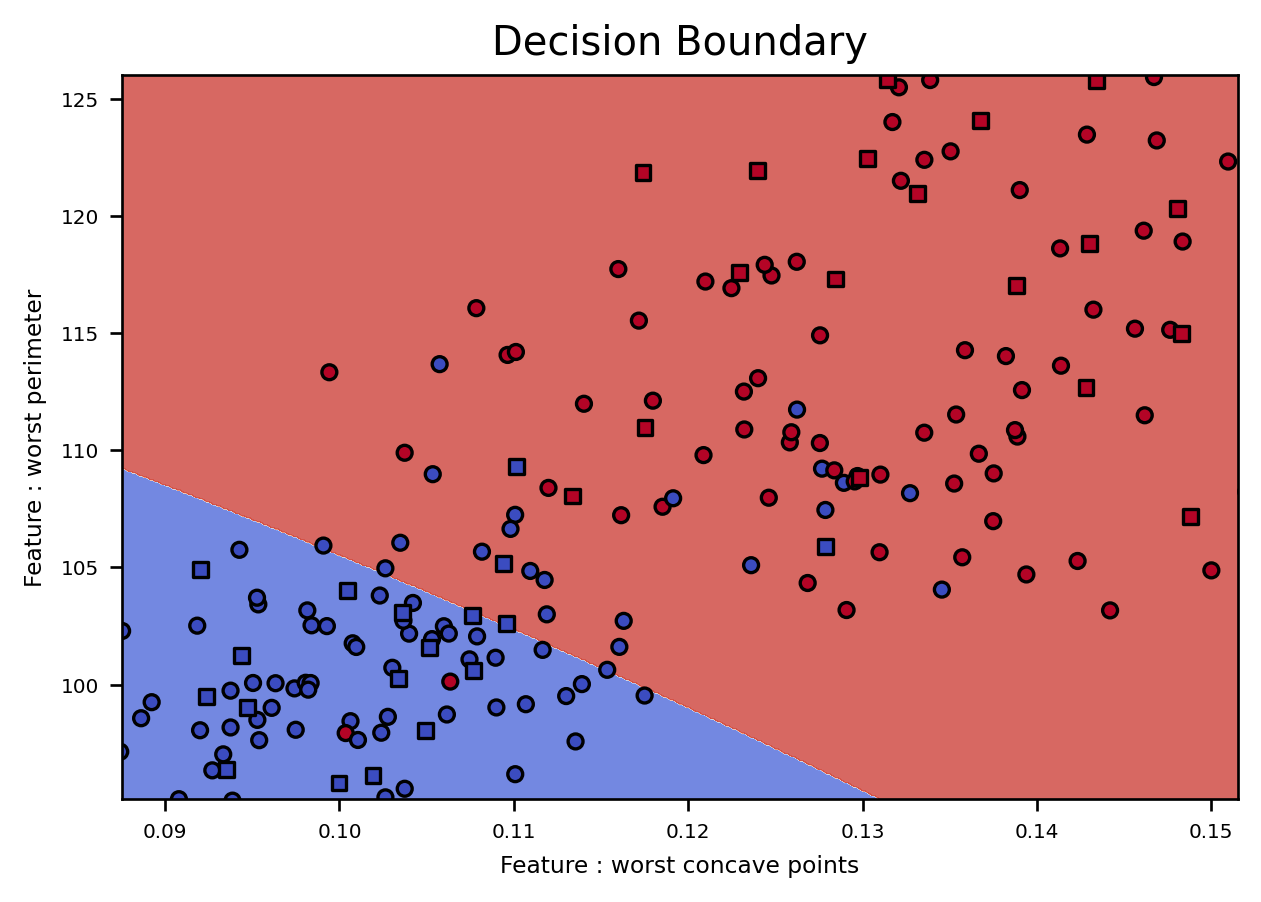

In [23]:
# Create an instance of SVM and fit our data. We do not scale our
# data since we want to plot the support vectors
# Concave points - Perimeter


n0=27
n1=22

x10, x90 = np.percentile(X_train.values[:,n0],[10,90])
y10, y90 = np.percentile(X_train.values[:,n1],[10,90])
xx, yy = make_meshgrid(np.array([x10, x90]), np.array([y10, y90]), 500)
svm_pl = Pipeline([('preproc',preproc_pl), ('svc', SVC(C=1.0))])
svm_pl = svm_pl.fit(X_train, y_train.values.reshape(-1,))
plot_contours(svm_pl, xx, yy, x_mean, n0, n1, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train.values[:,n0], X_train.values[:,n1], c=y_train.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
plt.scatter(X_val.values[:,n0], X_val.values[:,n1], c=y_val.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k", marker='s')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel(f"Feature : worst concave points")
plt.ylabel(f"Feature : worst perimeter")
plt.title("Decision Boundary")

plt.show()

/Users/trushaparam/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


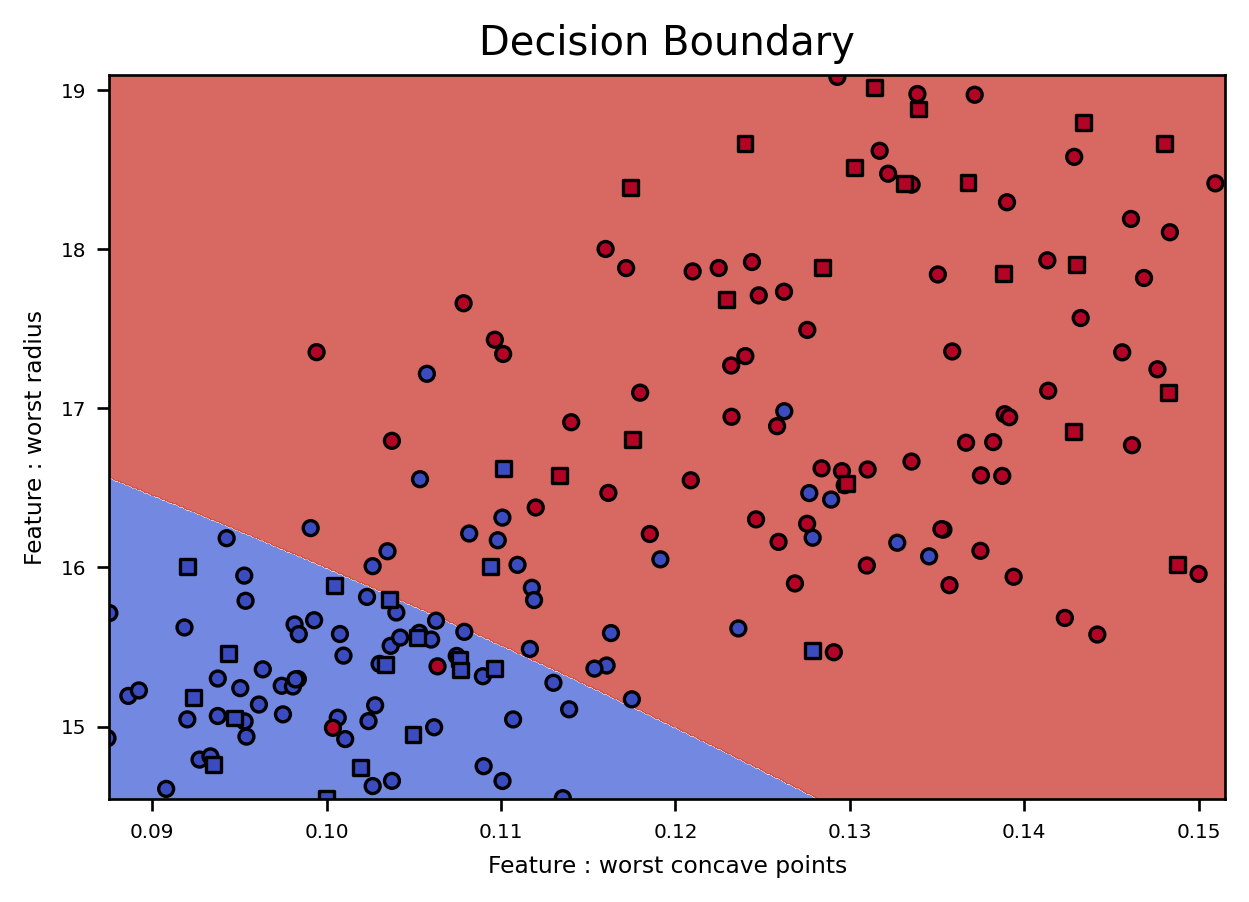

In [24]:
# w concave points(27) - w radius(20)

n0=27
n1=20

x10, x90 = np.percentile(X_train.values[:,n0],[10,90])
y10, y90 = np.percentile(X_train.values[:,n1],[10,90])
xx, yy = make_meshgrid(np.array([x10, x90]), np.array([y10, y90]), 500)

svm_pl = Pipeline([('preproc',preproc_pl), ('svc', SVC(C=1.0))])
svm_pl = svm_pl.fit(X_train, y_train.values.reshape(-1,))
plot_contours(svm_pl, xx, yy, x_mean, n0, n1, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train.values[:,n0], X_train.values[:,n1], c=y_train.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
plt.scatter(X_val.values[:,n0], X_val.values[:,n1], c=y_val.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k", marker='s')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel(f"Feature : worst concave points")
plt.ylabel(f"Feature : worst radius")
plt.title("Decision Boundary")

plt.show()

/Users/trushaparam/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


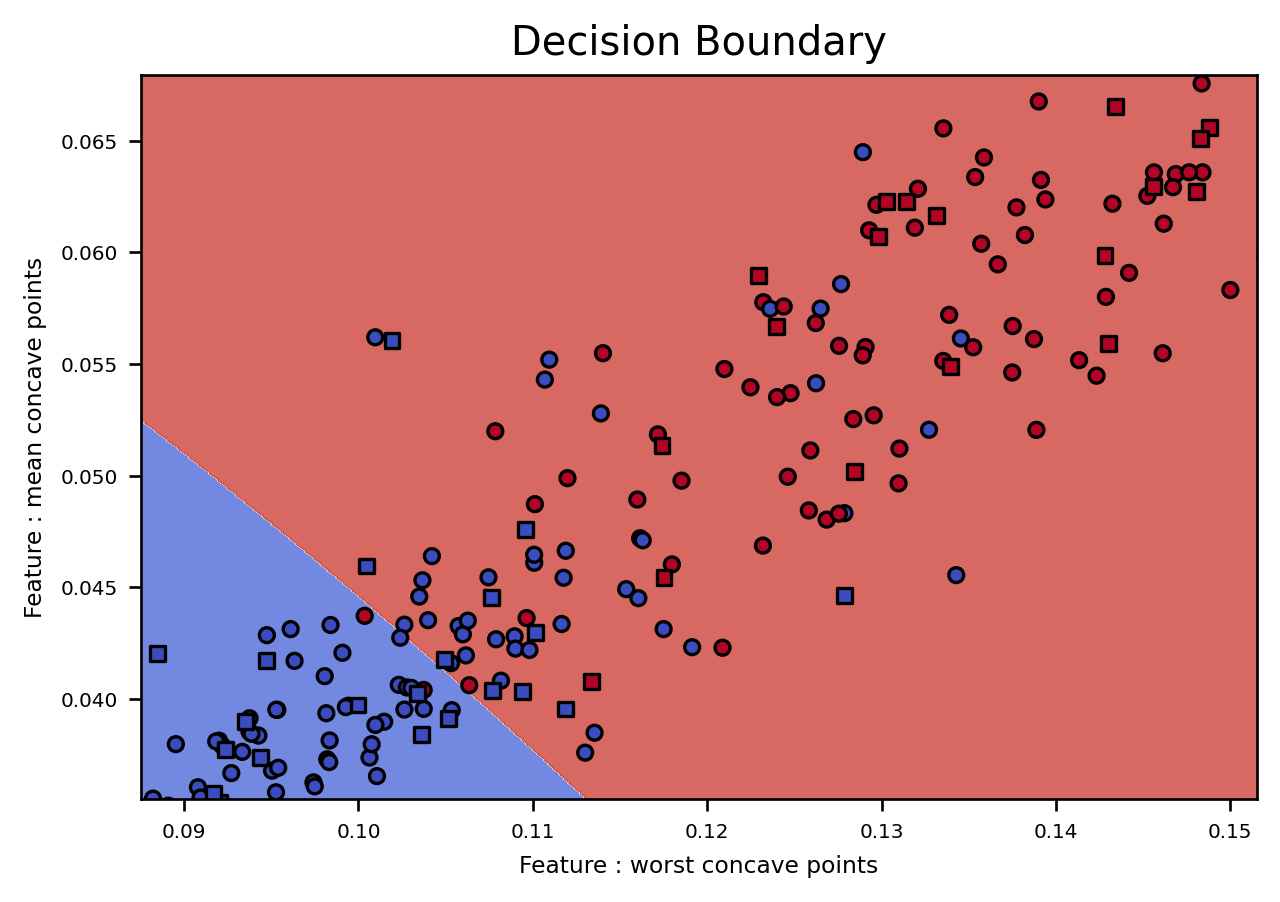

In [25]:
# w concave-points(27) - m concave points(7)
n0=27
n1=7

x10, x90 = np.percentile(X_train.values[:,n0],[10,90])
y10, y90 = np.percentile(X_train.values[:,n1],[10,90])
xx, yy = make_meshgrid(np.array([x10, x90]), np.array([y10, y90]), 500)

svm_pl = Pipeline([('preproc',preproc_pl), ('svc', SVC(C=1.0))])
svm_pl = svm_pl.fit(X_train, y_train.values.reshape(-1,))
plot_contours(svm_pl, xx, yy, x_mean, n0, n1, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train.values[:,n0], X_train.values[:,n1], c=y_train.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
plt.scatter(X_val.values[:,n0], X_val.values[:,n1], c=y_val.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k", marker='s')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel(f"Feature : worst concave points")
plt.ylabel(f"Feature : mean concave points")
plt.title("Decision Boundary")

plt.show()

/Users/trushaparam/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


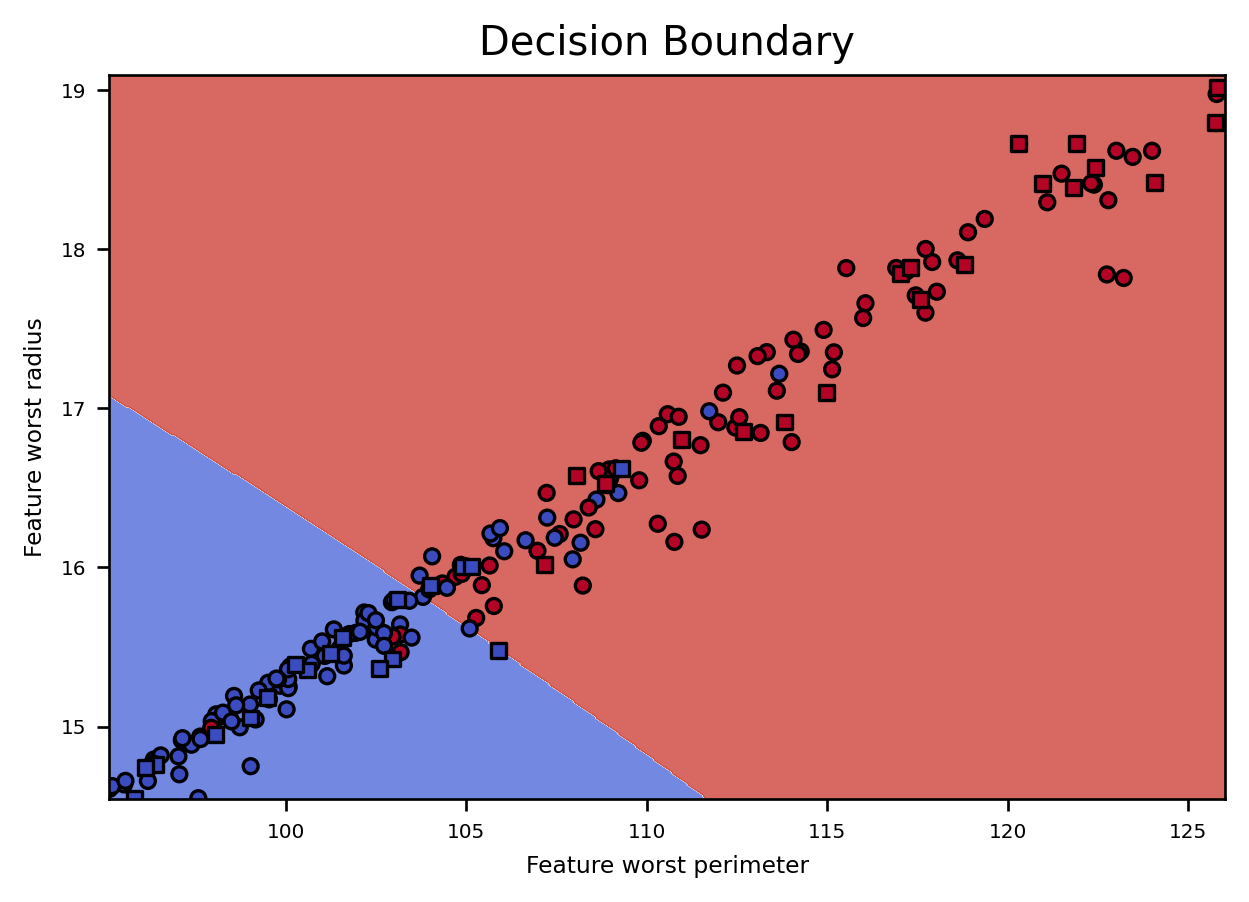

In [26]:
# w perimeter(22) - w radius(20)
n0=22
n1=20

x10, x90 = np.percentile(X_train.values[:,n0],[10,90])
y10, y90 = np.percentile(X_train.values[:,n1],[10,90])
xx, yy = make_meshgrid(np.array([x10, x90]), np.array([y10, y90]), 500)

svm_pl = Pipeline([('preproc',preproc_pl), ('svc', SVC(C=1.0))])
svm_pl = svm_pl.fit(X_train, y_train.values.reshape(-1,))
plot_contours(svm_pl, xx, yy, x_mean, n0, n1, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train.values[:,n0], X_train.values[:,n1], c=y_train.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
plt.scatter(X_val.values[:,n0], X_val.values[:,n1], c=y_val.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k", marker='s')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel(f"Feature worst perimeter")
plt.ylabel(f"Feature worst radius")
plt.title("Decision Boundary")

plt.show()

/Users/trushaparam/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


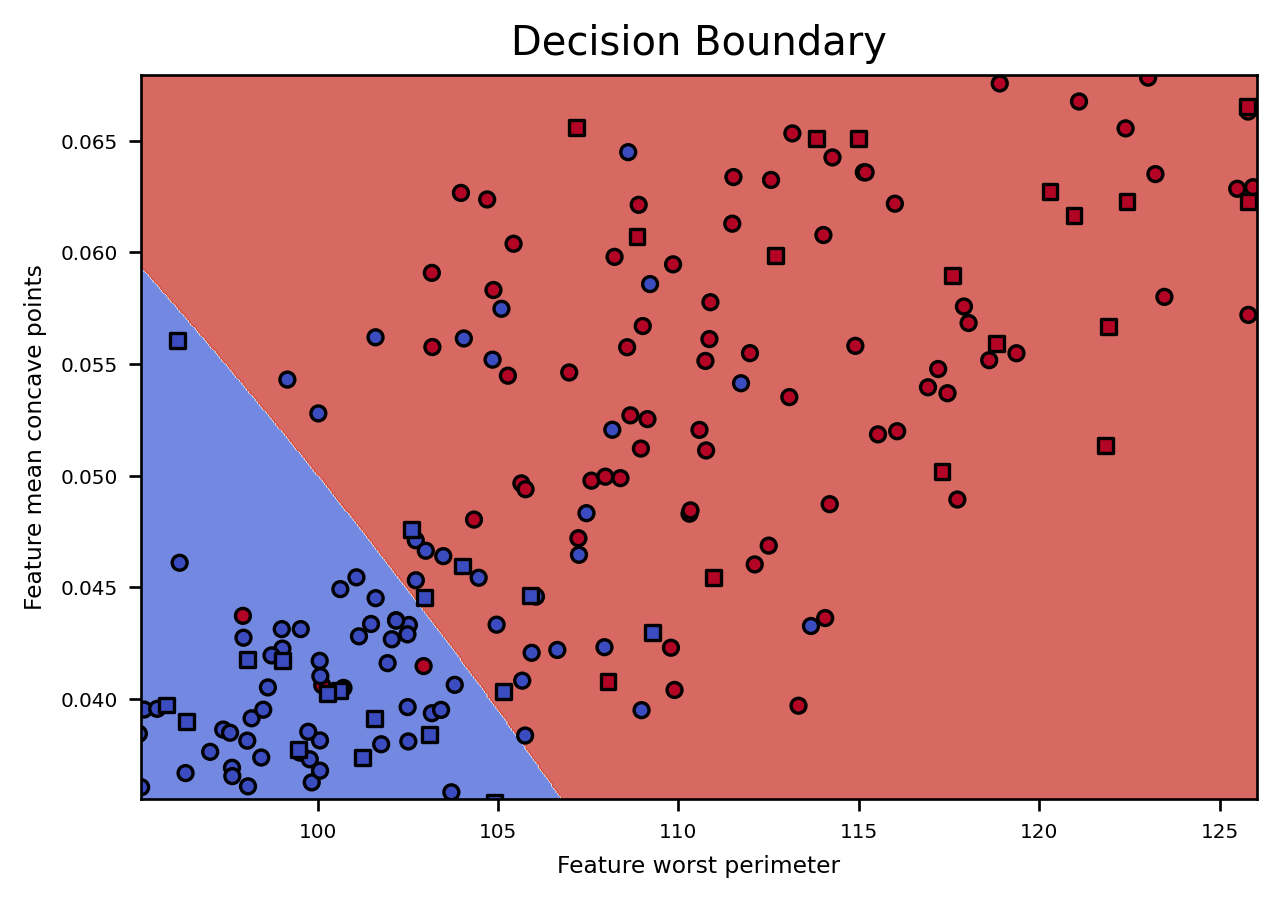

In [27]:
# w perimeter(22) - m concave points(7)
n0=22
n1=7

x10, x90 = np.percentile(X_train.values[:,n0],[10,90])
y10, y90 = np.percentile(X_train.values[:,n1],[10,90])
xx, yy = make_meshgrid(np.array([x10, x90]), np.array([y10, y90]), 500)

svm_pl = Pipeline([('preproc',preproc_pl), ('svc', SVC(C=1.0))])
svm_pl = svm_pl.fit(X_train, y_train.values.reshape(-1,))
plot_contours(svm_pl, xx, yy, x_mean, n0, n1, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train.values[:,n0], X_train.values[:,n1], c=y_train.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
plt.scatter(X_val.values[:,n0], X_val.values[:,n1], c=y_val.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k", marker='s')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel(f"Feature worst perimeter")
plt.ylabel(f"Feature mean concave points")
plt.title("Decision Boundary")

plt.show()

/Users/trushaparam/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


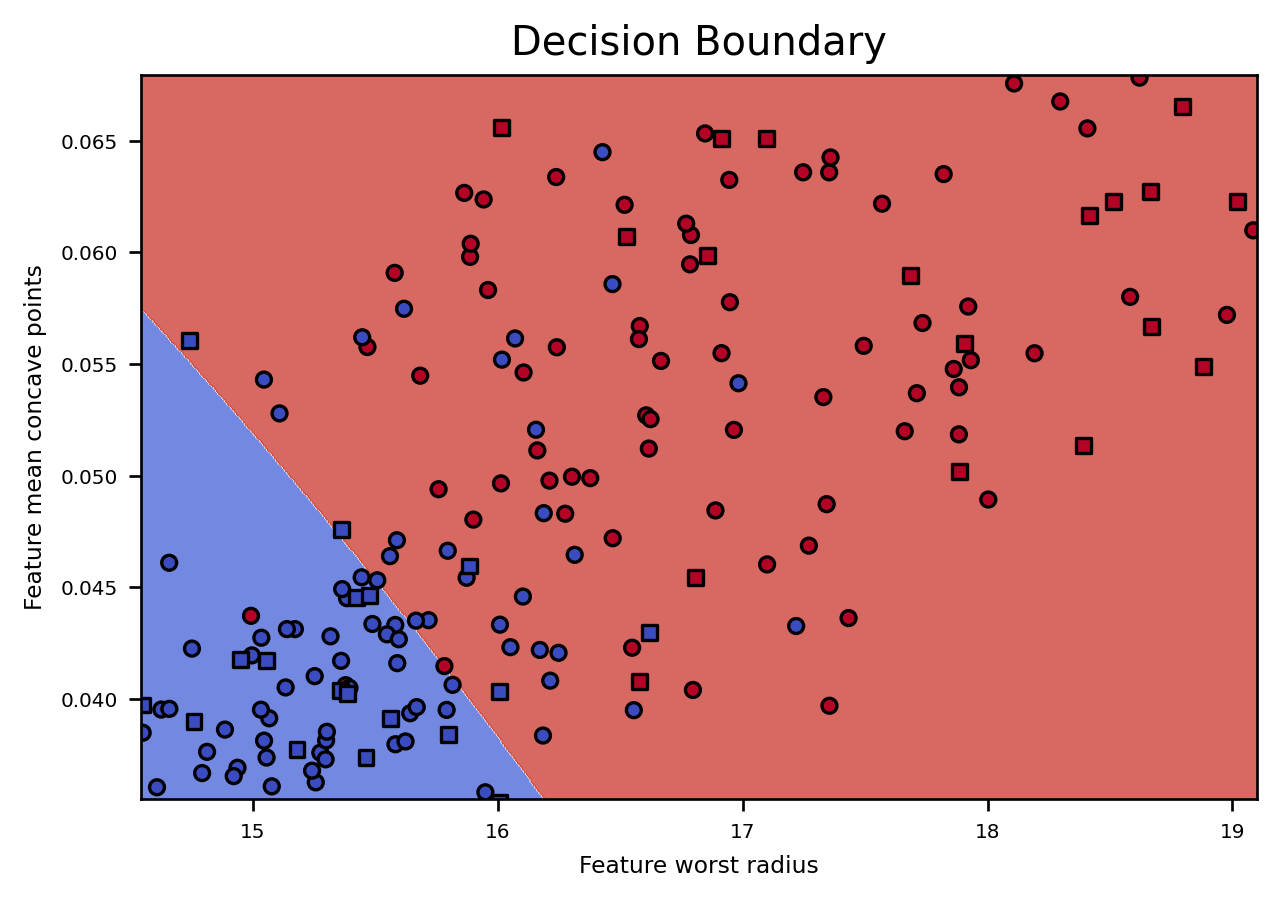

In [28]:
# w radius(20) - m concave points(7)
n0=20
n1=7

x10, x90 = np.percentile(X_train.values[:,n0],[10,90])
y10, y90 = np.percentile(X_train.values[:,n1],[10,90])
xx, yy = make_meshgrid(np.array([x10, x90]), np.array([y10, y90]), 500)

svm_pl = Pipeline([('preproc',preproc_pl), ('svc', SVC(C=1.0))])
svm_pl = svm_pl.fit(X_train, y_train.values.reshape(-1,))
plot_contours(svm_pl, xx, yy, x_mean, n0, n1, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train.values[:,n0], X_train.values[:,n1], c=y_train.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
plt.scatter(X_val.values[:,n0], X_val.values[:,n1], c=y_val.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k", marker='s')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel(f"Feature worst radius")
plt.ylabel(f"Feature mean concave points")
plt.title("Decision Boundary")

plt.show()

### 3.3 Interpretation 

Based on the displayed decision boundaries, we can say that the method extrapolates well. We can see that the blue points are in blue area and red are in red area. There are some misclassification but majority are okay.

## 4. Second Round 



### 4.1 New estimate

In [29]:
# Your code here
X_train_new = X_train.iloc[:,:20]
X_test_new = X_test.iloc[:,:20]
X_val_new = X_val.iloc[:,:20]

In [30]:
# KNN classifier
knn_new = knn_function(X_train_new.values, X_val_new.values)
print(f'Best params using KNN classifier is {knn_new}')


# Decison tree classifier
dtc_new = dtc_function(X_train_new.values, X_val_new.values)
print(f'\nBest params using Decison Tree classifier is {dtc_new}')


# SVM classifier
svm_new = svm_function(X_train_new.values, X_val_new.values)
print(f'\nBest params using SVM classifier is {svm_new}')


# SGD classifier
sgd_new = sgd_function(X_train_new.values, X_val_new.values)
print(f'\nBest params using SGD classifier is {sgd_new}')


Best params using KNN classifier is {'knn__n_neighbors': 3}

Best params using Decison Tree classifier is {'dtc__ccp_alpha': 1.0}

Best params using SVM classifier is {'svc__C': 3.0}

Best params using SGD classifier is {'sgd__alpha': 1.0}


In [31]:
# pipelines
knn_o = optimal_knn(X_train_new.values, X_val_new.values, 3)
print(f'Balanced Accuracy for KNN classifier is {knn_o[0]}')
print(f'fbeta score(beta = 10) for KNN classifier is {knn_o[1]}')

dt_o = optimal_dt(X_train_new.values, X_val_new.values, 1.0)
print(f'\nBalanced Accuracy for Decision Tree classifier is {dt_o[0]}')
print(f'fbeta score(beta = 10) for Decision Tree classifier is {dt_o[1]}')

svm_o = optimal_svm(X_train_new.values, X_val_new.values, 3.0)
print(f'\nBalanced Accuracy for SVM classifier is {svm_o[0]}')
print(f'fbeta score(beta = 10) for SVM classifier is {svm_o[1]}')

sgd_o = optimal_sgd(X_train_new.values, X_val_new.values, 1.0)
print(f'\nBalanced Accuracy for SGD classifier is {sgd_o[0]}')
print(f'fbeta score(beta = 10) for SGD classifier is {sgd_o[1]}')

Balanced Accuracy for KNN classifier is 0.9337944664031621
fbeta score(beta = 10) for KNN classifier is 0.9541160593792173

Balanced Accuracy for Decision Tree classifier is 0.5
fbeta score(beta = 10) for Decision Tree classifier is 0.0

Balanced Accuracy for SVM classifier is 0.9337944664031621
fbeta score(beta = 10) for SVM classifier is 0.9541160593792173

Balanced Accuracy for SGD classifier is 0.9090909090909092
fbeta score(beta = 10) for SGD classifier is 0.8196573489630299


In [32]:
# Choose SVM classifier as the optimal classifier

svm_0 = optimal_svm_test(X_train_new.values, X_test_new.values, 3.0)
print(f'Balanced Accuracy for SVM classifier is {svm_o[0]}')
print(f'fbeta score(beta = 10) for SVM classifier is {svm_o[1]}')

Balanced Accuracy for SVM classifier is 0.9337944664031621
fbeta score(beta = 10) for SVM classifier is 0.9541160593792173


### 4.2 Performance difference 

From the values that we obtained, we can say that the previous classifier is slightly good which has all the features than the classifier which does not have "worst" features. 
